# ECOv003 JET Accuracy Analysis with ECOv002 Cal-Val - Calibration Comparison

This notebook compares the accuracy of the JET ensemble using ECOSTRESS Collection 2 Cal-Val data **with and without calibration** applied to air temperature (Ta), relative humidity (RH), and soil moisture (SM).

The notebook shows side-by-side comparisons to demonstrate the impact of calibration on model accuracy.

## Overview

This notebook demonstrates the impact of calibration on JET ensemble model accuracy by:

1. **Processing data twice**: Once without calibration (baseline) and once with calibration applied to meteorological inputs (Ta, RH, SM)
2. **Creating side-by-side comparisons**: All figures show both uncalibrated (left) and calibrated (right) results
3. **Quantifying improvements**: R² and RMSE metrics are shown for both versions to measure calibration effectiveness

The calibration corrects systematic biases in:
- **Air Temperature (Ta_C)**: Temperature measurements from GEOS-5 FP
- **Relative Humidity (RH)**: Humidity measurements from GEOS-5 FP  
- **Soil Moisture (SM)**: Soil moisture measurements from SMAP

## Import Required Libraries and Functions

This cell imports all necessary libraries and functions for data processing, model execution, statistical analysis, and plotting. It includes custom modules for the JET ensemble, sensitivity analysis, and net radiation calculations, as well as standard scientific Python libraries.

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
from typing import Callable
from os import makedirs
from os.path import join
import numpy as np
import pandas as pd
from verma_net_radiation import verma_net_radiation_table
from JET3 import process_JET_table, load_ECOv002_calval_JET_inputs
from monte_carlo_sensitivity import perturbed_run, sensitivity_analysis, divide_absolute_by_unperturbed, sensitivity_magnitude_barchart
import matplotlib.pyplot as plt
from scipy.stats import mstats
import seaborn as sns
from matplotlib.ticker import FuncFormatter

## Configuration Options

Set configuration options for the notebook, including whether to save plots to files.

In [2]:
# Configuration: Set to True to save plots to files, False to only display them
SAVE_PLOTS = False

In [3]:
input_variables = [
    "ST_C",
    "NDVI",
    "albedo",
    "Ta_C",
    "RH",
    "AOT",
    "COT",
    "vapor_gccm",
    "ozone_cm",
    "elevation_m",
    "canopy_height_meters"
]

output_variables = [
    "Rn_Wm2",
    "ET_daylight_kg",
    "GPP_inst_g_m2_s"
]

# Per-variable physical bounds to keep perturbations realistic
input_min = {
    "ST_C": 0.0,
    "NDVI": 0.05,
    "albedo": 0.0,
    "Ta_C": 0.0,
    "RH": 0.0,
    "AOT": 0.0,
    "COT": 0.0,
    "vapor_gccm": 0.0,
    "ozone_cm": 0.0,
    "elevation_m": 0.0,
    "canopy_height_meters": 0.0,
}

input_max = {
    "ST_C": 50.0,
    "NDVI": 1,
    "albedo": 1,
}

## Define Processing Function for Model Table

This cell defines the forward process for analysis as the BESS-JPL model.

In [4]:
forward_process = process_JET_table
model_name = "JET"

## Set Normalization Function

This cell assigns the normalization function used to compare perturbed model outputs to the unperturbed baseline. The function `divide_absolute_by_unperturbed` is used for normalization in the sensitivity analysis.

In [5]:
normalization_function = divide_absolute_by_unperturbed

## Load and Filter Input Data

This cell loads the ECOSTRESS Cal-Val input data using a custom loader function and filters out surface temperatures greater than 50 Celsius and NDVI values less than 0.05. The resulting DataFrame is displayed for inspection.

In [6]:
input_df = load_ECOv002_calval_JET_inputs()

# Apply lower and upper bounds from configuration dictionaries
mask = pd.Series(True, index=input_df.index)
for var, min_val in input_min.items():
    if var in input_df.columns:
        mask &= input_df[var] >= min_val
for var, max_val in input_max.items():
    if var in input_df.columns:
        mask &= input_df[var] <= max_val

input_df = input_df[mask]
input_df = input_df.dropna()
input_df

,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,CL,Tmin_open,Tmin_closed,VPD_open,VPD_closed,Tmin_C,Topt_C,fAPARmax,field_capacity,wilting_point
15,15,US-xAB,ENF,Csb,141.635670,168.24043,402.81810,159.71700,139.016083,107.183200,...,0.0032,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16
17,17,US-xAB,ENF,Csb,1.881266,163.94730,301.40400,179.13661,131.273636,106.525215,...,0.0032,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16
18,18,US-xAB,ENF,Csb,3.135606,246.87700,614.51480,405.50497,366.056641,222.890230,...,0.0032,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16
19,19,US-xAB,ENF,Csb,311.482820,290.73126,672.27510,478.82382,439.821228,153.787670,...,0.0032,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16
20,20,US-xAB,ENF,Csb,51.920338,95.28810,116.67136,73.20884,232.693512,24.038680,...,0.0032,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,992,US-xML,DBF,Dfb,417.831120,706.93066,523.92740,310.69684,356.174072,148.624050,...,0.0065,11.39,-8.0,650.0,3500.0,27.538052,2.66,0.5404,0.34,0.14
994,994,US-xML,DBF,Dfb,161.558200,306.15277,420.44678,206.48576,237.659103,98.727560,...,0.0065,11.39,-8.0,650.0,3500.0,27.538052,2.66,0.5404,0.34,0.14
1001,1001,US-UiB,CRO,Dfa,93.876100,251.38747,238.71077,198.90399,106.316444,67.694800,...,0.0070,12.02,-8.0,650.0,4500.0,9.637029,2.58,0.4060,0.32,0.14
1020,1020,US-ARM,CRO,Cfa,80.255005,0.00000,180.10085,211.28325,164.581390,84.672410,...,0.0070,12.02,-8.0,650.0,4500.0,9.637029,8.48,0.4017,0.29,0.12


## Process Input Data Through Model

This cell applies the processing function to the filtered input data, running it through the model, and displays the resulting DataFrame.

In [7]:
# Process data WITHOUT calibration
print("Processing WITHOUT calibration...")
processed_uncalibrated = forward_process(input_df, use_calibration=False)
processed_uncalibrated

# Process data WITH calibration  
print("\nProcessing WITH calibration...")
processed_calibrated = forward_process(input_df, use_calibration=True)
processed_calibrated

Processing WITHOUT calibration...
[2026-02-27 10:53:26 INFO] starting JET table processing
[2026-02-27 10:53:26 INFO] started extracting geometry from JET input table
[2026-02-27 10:53:26 INFO] completed extracting geometry from JET input table (0.003 seconds)
[2026-02-27 10:53:26 INFO] started extracting time from JET input table
[2026-02-27 10:53:26 INFO] completed extracting time from JET input table (0.001 seconds)
[2026-02-27 10:53:26 INFO] running Forest Light Environmental Simulator
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[2026-02-27 10:53:26 INFO] completed processing FLiES-ANN in 0.15 seconds
[2026-02-27 10:53:26 INFO] variable PAR_albedo min: 0.007 mean: 0.055 max: 0.193 nan: 0.00% (nan)
[2026-02-27 10:53:26 INFO] variable NIR_albedo min: 0.066 mean: 0.162 max: 0.530 nan: 0.00% (nan)
[2026-02-27 10:53:26 INFO] variable PAR_direct_Wm2 min: 7.148 mean: 269.735 max: 442.463 nan: 0.00% (nan)
[2026-02-27 10:53:26 INFO] variable SWin_FLiES_ANN min: 163.676 mean: 716.916 max: 1095.605

,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,ET_daylight_PMJPL_kg,G_PMJPL_Wm2,G_Wm2,LE_instantaneous_Wm2,ET_daylight_kg,ET_uncertainty,GPP_inst_g_m2_s,ET_canopy_inst_kg_m2_s,WUE,AuxiliaryNWP
15,15,US-xAB,ENF,Csb,141.635670,168.24043,402.81810,159.71700,139.016083,107.183200,...,2.801589,24.232924,24.232924,235.004622,3.344676,0.811325,0.000151,0.000100,1.519952,
17,17,US-xAB,ENF,Csb,1.881266,163.94730,301.40400,179.13661,131.273636,106.525215,...,2.783958,13.888571,13.888571,208.788803,3.634896,1.116933,0.000108,0.000072,1.497547,
18,18,US-xAB,ENF,Csb,3.135606,246.87700,614.51480,405.50497,366.056641,222.890230,...,4.063770,33.053500,33.053500,375.255018,4.865916,1.183193,0.000291,0.000173,1.677395,
19,19,US-xAB,ENF,Csb,311.482820,290.73126,672.27510,478.82382,439.821228,153.787670,...,4.385870,42.253985,42.253985,376.522864,4.622162,1.329070,0.000294,0.000204,1.436631,
20,20,US-xAB,ENF,Csb,51.920338,95.28810,116.67136,73.20884,232.693512,24.038680,...,4.020650,2.990681,2.990681,118.701271,3.149331,0.754490,0.000095,0.000010,9.130613,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,992,US-xML,DBF,Dfb,417.831120,706.93066,523.92740,310.69684,356.174072,148.624050,...,3.500136,29.141253,29.141253,375.417816,3.438145,0.941759,0.000233,0.000133,1.751269,
994,994,US-xML,DBF,Dfb,161.558200,306.15277,420.44678,206.48576,237.659103,98.727560,...,3.192998,21.272888,21.272888,282.035514,2.848649,1.064079,0.000138,0.000100,1.382509,
1001,1001,US-UiB,CRO,Dfa,93.876100,251.38747,238.71077,198.90399,106.316444,67.694800,...,0.541116,76.673547,76.673547,89.036541,1.108975,1.255443,0.000053,0.000022,2.366093,
1020,1020,US-ARM,CRO,Cfa,80.255005,0.00000,180.10085,211.28325,164.581390,84.672410,...,0.724623,68.376990,68.376990,118.650430,1.399859,1.418580,0.000048,0.000035,1.376374,



Air Temperature Calibration Summary:
  Mean Uncalibrated: 22.343 °C
  Mean Calibrated: 21.155 °C
  Mean Adjustment: -1.187 °C

Relative Humidity Calibration Summary:
  Mean Uncalibrated: 0.388 
  Mean Calibrated: 0.261 
  Mean Adjustment: -0.126 

Soil Moisture Calibration Summary:
  Mean Uncalibrated: 0.144 m³/m³
  Mean Calibrated: 0.106 m³/m³
  Mean Adjustment: -0.038 m³/m³


/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_76501/187706864.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


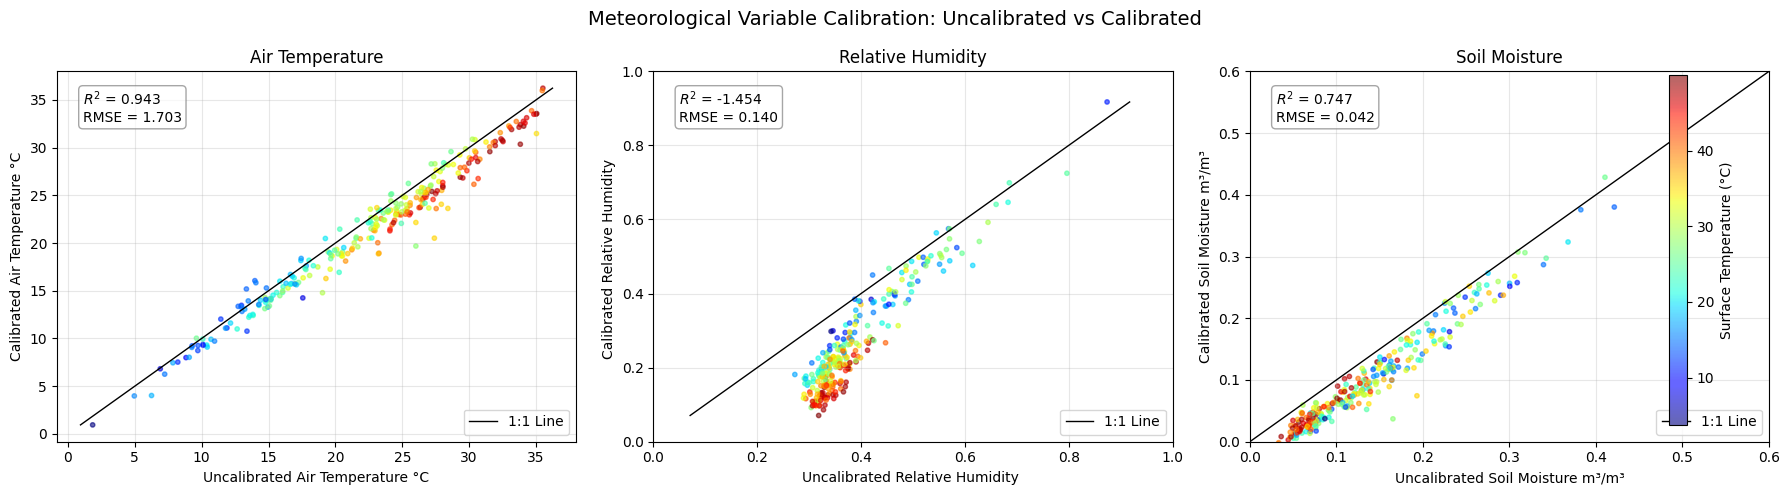

In [17]:
# Create scatter plots comparing uncalibrated vs calibrated meteorological variables
from sklearn.metrics import r2_score, mean_squared_error

# Dictionary of variables to compare with their display names and units
met_variables = {
    'Ta_C': {'name': 'Air Temperature', 'unit': '°C', 'xlim': None, 'ylim': None},
    'RH': {'name': 'Relative Humidity', 'unit': '', 'xlim': [0, 1], 'ylim': [0, 1]},
    'SM': {'name': 'Soil Moisture', 'unit': 'm³/m³', 'xlim': [0, 0.6], 'ylim': [0, 0.6]}
}

# Create one figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (var, info) in enumerate(met_variables.items()):
    ax = axes[idx]
    
    # Filter valid data
    if var in input_df.columns and var in processed_uncalibrated.columns and var in processed_calibrated.columns:
        valid_idx = input_df[var].notna() & processed_uncalibrated[var].notna() & processed_calibrated[var].notna()
        
        if valid_idx.sum() == 0:
            print(f"No valid data for {var}")
            continue
        
        uncal_vals = processed_uncalibrated.loc[valid_idx, var]
        cal_vals = processed_calibrated.loc[valid_idx, var]
        st_c = processed_uncalibrated.loc[valid_idx, 'ST_C']
        
        # Uncalibrated (x) vs Calibrated (y)
        sc = ax.scatter(x=uncal_vals, y=cal_vals, 
                       c=st_c, cmap='jet', s=10, alpha=0.6)
        
        # Calculate correlation
        if len(uncal_vals) > 1:
            r2 = r2_score(uncal_vals, cal_vals)
            rmse = np.sqrt(mean_squared_error(uncal_vals, cal_vals))
            ax.annotate(f"$R^2$ = {r2:.3f}\nRMSE = {rmse:.3f}",
                       xy=(0.05, 0.95), xycoords='axes fraction',
                       ha='left', va='top', fontsize=10,
                       bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.7))
        
        # 1:1 line
        lims = [min(uncal_vals.min(), cal_vals.min()), max(uncal_vals.max(), cal_vals.max())]
        ax.plot(lims, lims, 'k-', linewidth=1, label='1:1 Line')
        ax.set_xlabel(f'Uncalibrated {info["name"]} {info["unit"]}')
        ax.set_ylabel(f'Calibrated {info["name"]} {info["unit"]}')
        ax.set_title(f'{info["name"]}')
        ax.grid(True, alpha=0.3)
        ax.legend()
        if info['xlim']:
            ax.set_xlim(info['xlim'])
            ax.set_ylim(info['ylim'])
        
        # Print summary
        print(f"\n{info['name']} Calibration Summary:")
        print(f"  Mean Uncalibrated: {uncal_vals.mean():.3f} {info['unit']}")
        print(f"  Mean Calibrated: {cal_vals.mean():.3f} {info['unit']}")
        print(f"  Mean Adjustment: {(cal_vals.mean() - uncal_vals.mean()):.3f} {info['unit']}")
    else:
        print(f"Variable {var} not found in all dataframes")

# Add colorbar on the right side
fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
fig.colorbar(sc, cax=cbar_ax, label='Surface Temperature (°C)')

plt.suptitle('Meteorological Variable Calibration: Uncalibrated vs Calibrated', fontsize=14, y=0.98)

if SAVE_PLOTS:
    plt.savefig('Met_Variables_Calibration_Comparison.jpeg', format='jpeg', bbox_inches='tight', dpi=150)
    plt.savefig('Met_Variables_Calibration_Comparison.svg', format='svg', bbox_inches='tight')

plt.tight_layout()
plt.show()

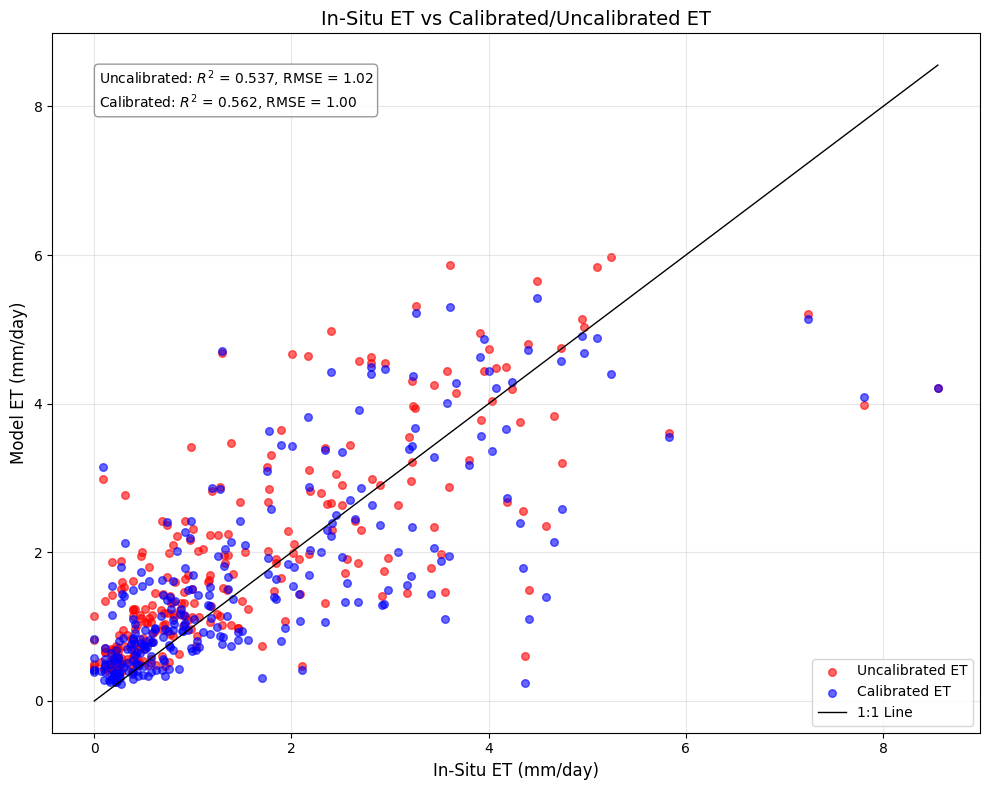

In [ ]:
# Scatter plot: Insitu ET vs Calibrated/Uncalibrated ET
fig, ax = plt.subplots(figsize=(10, 8))

# Get valid data for both calibrated and uncalibrated
insitu_et = processed_calibrated['insitu_ET_daylight_kg'].dropna()
uncal_et = processed_uncalibrated.loc[insitu_et.index, 'ET_daylight_kg']
cal_et = processed_calibrated.loc[insitu_et.index, 'ET_daylight_kg']

# Remove any remaining NaN values
valid_mask = uncal_et.notna() & cal_et.notna()
insitu_et = insitu_et[valid_mask]
uncal_et = uncal_et[valid_mask]
cal_et = cal_et[valid_mask]

# Scatter plots
ax.scatter(insitu_et, uncal_et, c='red', s=30, alpha=0.6, label='Uncalibrated ET')
ax.scatter(insitu_et, cal_et, c='blue', s=30, alpha=0.6, label='Calibrated ET')

# 1:1 line
min_val = min(insitu_et.min(), uncal_et.min(), cal_et.min())
max_val = max(insitu_et.max(), uncal_et.max(), cal_et.max())
ax.plot([min_val, max_val], [min_val, max_val], 'k-', linewidth=1, label='1:1 Line')

# OLS regression line for uncalibrated
coefs_uncal = np.polyfit(insitu_et, uncal_et, 1)
ols_x = np.array([min_val, max_val])
ols_y_uncal = coefs_uncal[0] * ols_x + coefs_uncal[1]
ax.plot(ols_x, ols_y_uncal, 'r--', linewidth=1.5, label='Uncalibrated OLS Fit')

# OLS regression line for calibrated
coefs_cal = np.polyfit(insitu_et, cal_et, 1)
ols_y_cal = coefs_cal[0] * ols_x + coefs_cal[1]
ax.plot(ols_x, ols_y_cal, 'b--', linewidth=1.5, label='Calibrated OLS Fit')

# Calculate R² and RMSE for both
r2_uncal = r2_score(insitu_et, uncal_et)
rmse_uncal = np.sqrt(mean_squared_error(insitu_et, uncal_et))
r2_cal = r2_score(insitu_et, cal_et)
rmse_cal = np.sqrt(mean_squared_error(insitu_et, cal_et))

# Add statistics text box
stats_text = f"Uncalibrated: $R^2$ = {r2_uncal:.3f}, RMSE = {rmse_uncal:.2f}\n"
stats_text += f"Calibrated: $R^2$ = {r2_cal:.3f}, RMSE = {rmse_cal:.2f}"
ax.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction',
            ha='left', va='top', fontsize=10,
            bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))

ax.set_xlabel('In-Situ ET (mm/day)', fontsize=12)
ax.set_ylabel('Model ET (mm/day)', fontsize=12)
ax.set_title('In-Situ ET vs Calibrated/Uncalibrated ET', fontsize=14)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()

if SAVE_PLOTS:
    plt.savefig('Insitu_ET_vs_Calibrated_Uncalibrated_ET.jpeg', format='jpeg', bbox_inches='tight', dpi=150)
    plt.savefig('Insitu_ET_vs_Calibrated_Uncalibrated_ET.svg', format='svg', bbox_inches='tight')

plt.show()

## Accuracy Comparison: Uncalibrated vs Calibrated

Comparing model accuracy with and without calibration applied to meteorological inputs (Ta, RH, SM).

Examining the accuracy of model estimates compared to ground data.

analyzing JET accuracy for ET_daylight_kg compared to insitu_ET_daylight_kg


/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_76501/1028714077.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


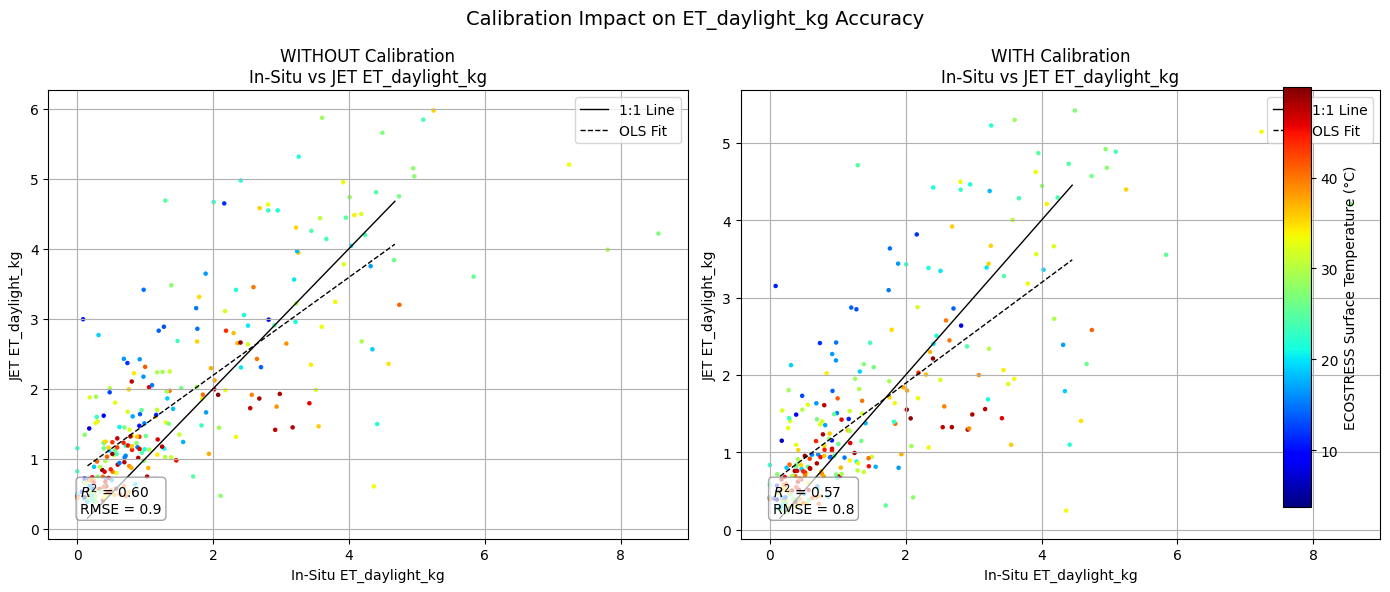

analyzing JET accuracy for G_Wm2 compared to insitu_G_Wm2


/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_76501/1028714077.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


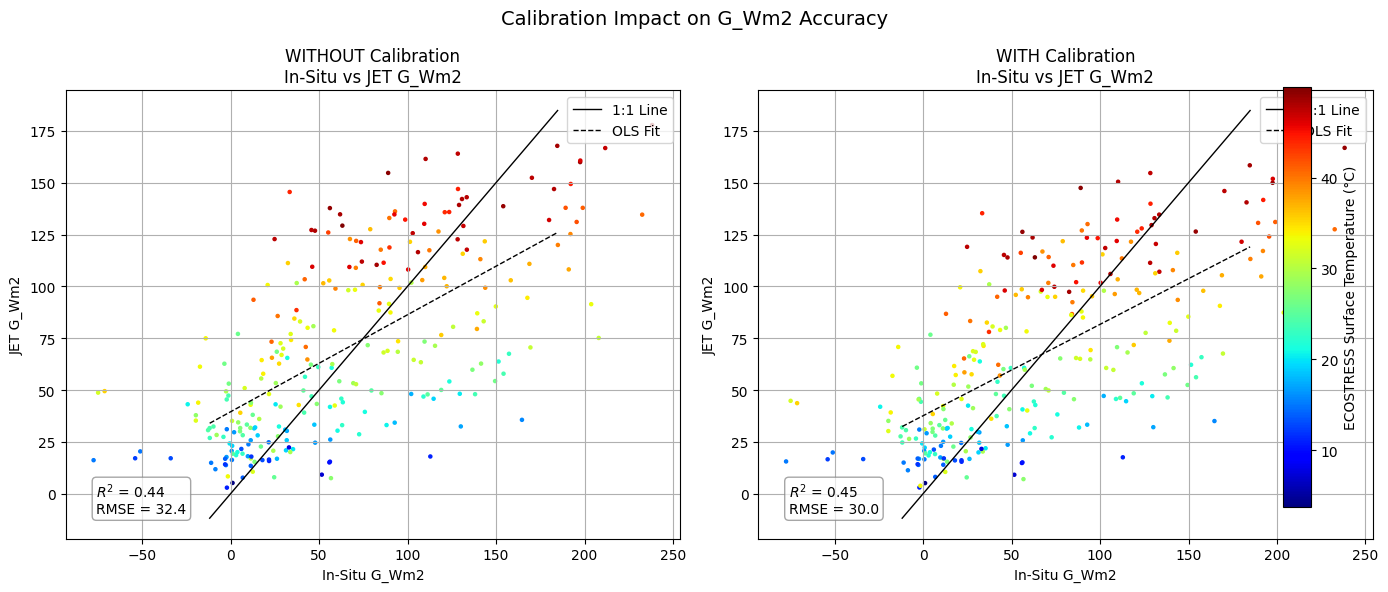

analyzing JET accuracy for H_Wm2 compared to insitu_H_Wm2


/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_76501/1028714077.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


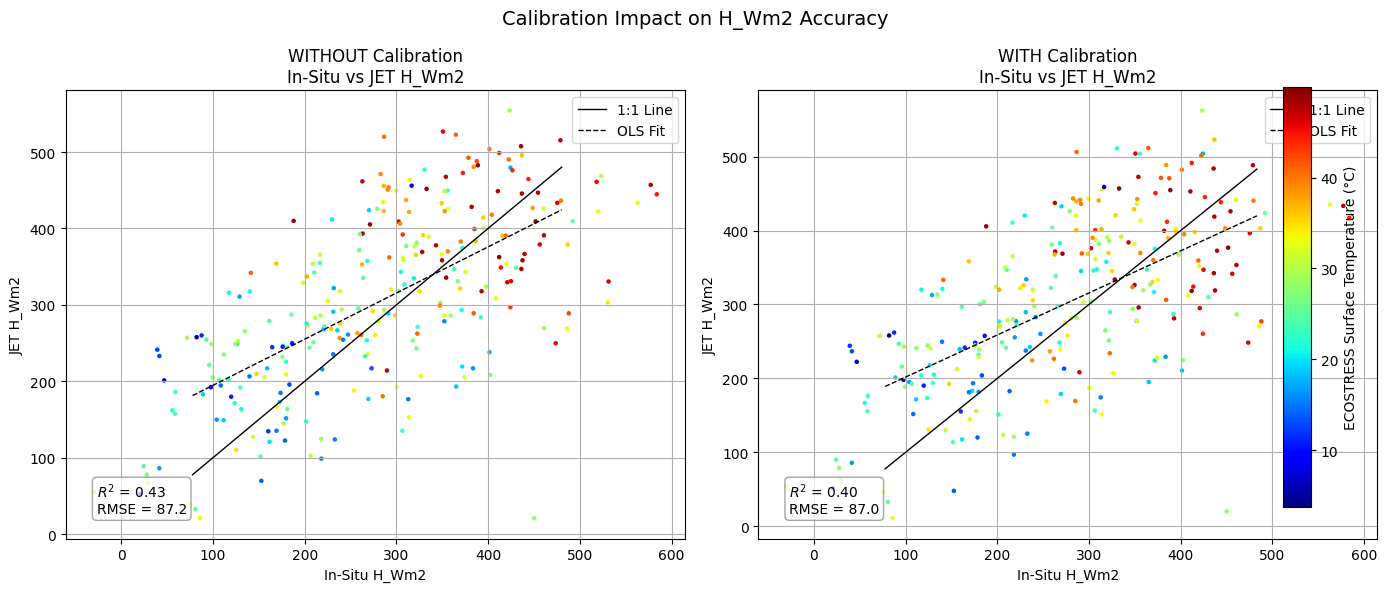

analyzing JET accuracy for LE_Wm2 compared to insitu_LE_Wm2


/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_76501/1028714077.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


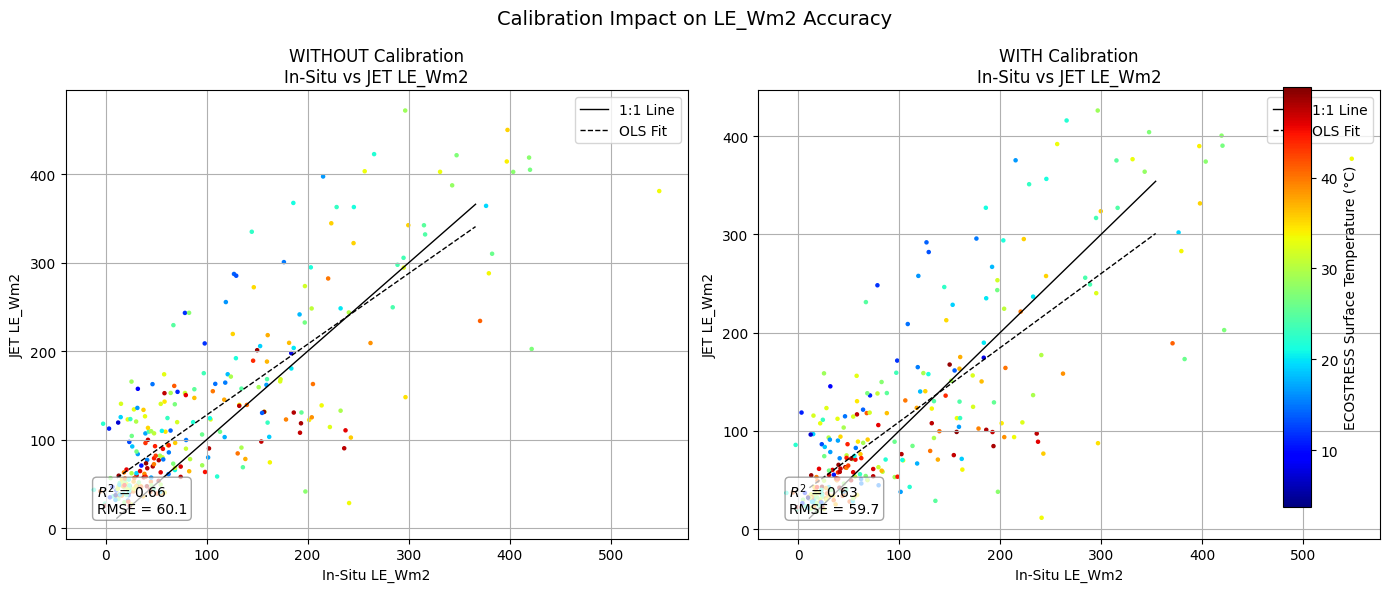

analyzing JET accuracy for LE_daylight_Wm2 compared to insitu_LE_daylight_Wm2
Error processing LE_daylight_Wm2: "['LE_daylight_Wm2'] not in index"
analyzing JET accuracy for RH compared to insitu_RH


Traceback (most recent call last):
  File "/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_76501/1028714077.py", line 17, in <module>
    valid_data_uncal = processed_uncalibrated[[x_variable, y_variable, 'ST_C']].dropna()
                       ~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniforge/base/envs/JET3/lib/python3.12/site-packages/pandas/core/frame.py", line 4384, in __getitem__
    indexer = self.columns._get_indexer_strict(key, "columns")[1]
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniforge/base/envs/JET3/lib/python3.12/site-packages/pandas/core/indexes/base.py", line 6302, in _get_indexer_strict
    self._raise_if_missing(keyarr, indexer, axis_name)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/JET3/lib/python3.12/site-packages/pandas/core/indexes/base.py", line 6355, in _raise_if_missing
    raise KeyError(f"{not_found} not in index")
KeyError: "['LE_daylight

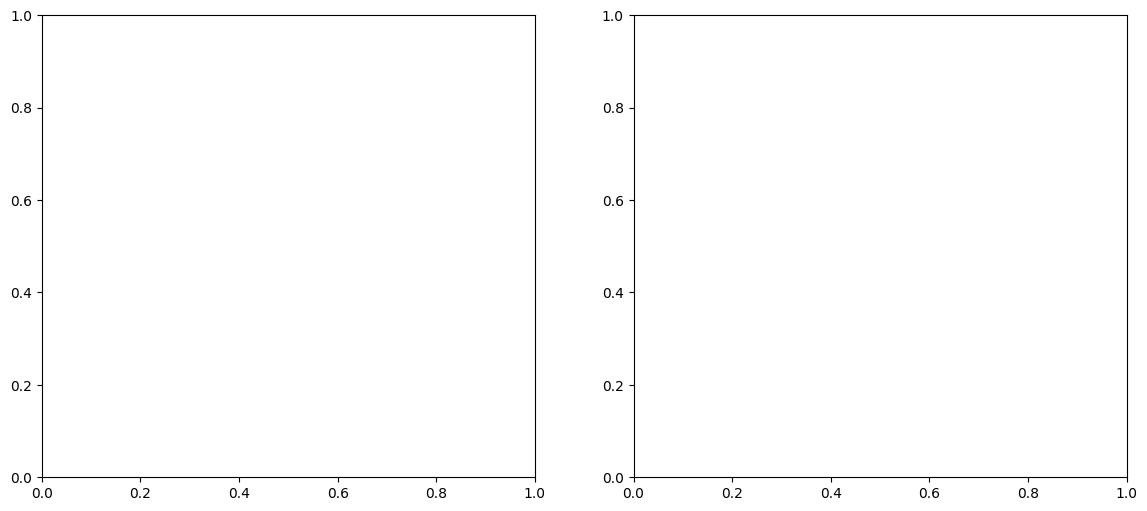

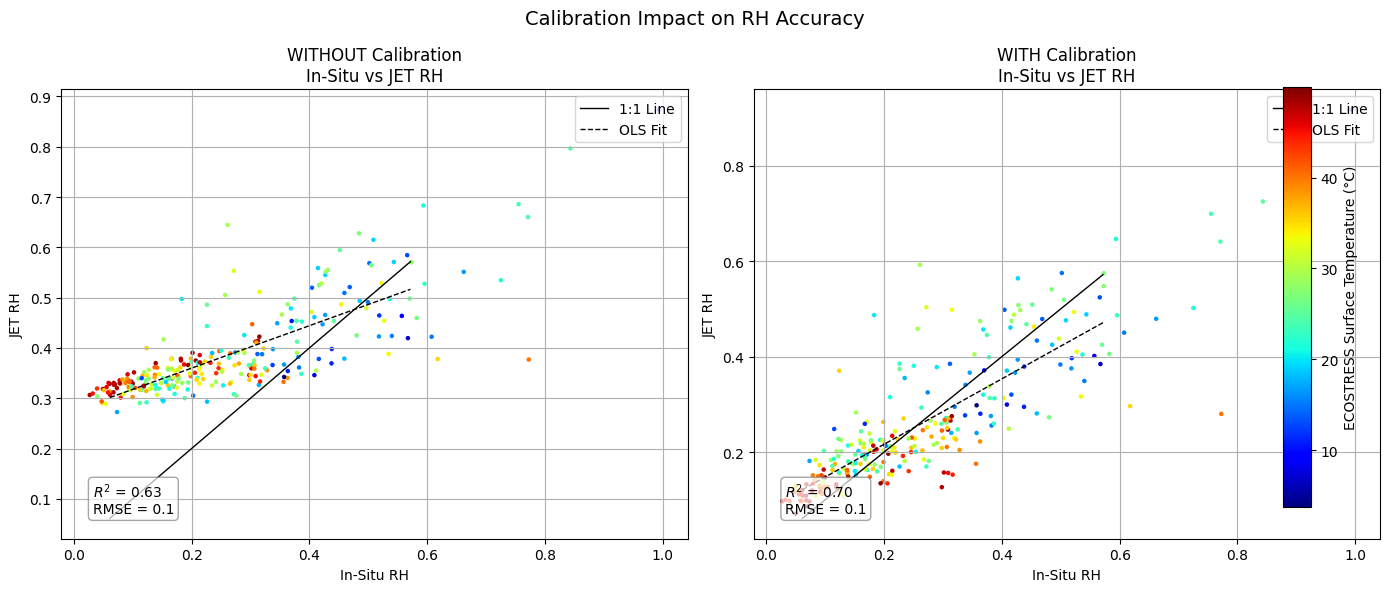

/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_76501/1028714077.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


analyzing JET accuracy for Rn_Wm2 compared to insitu_Rn_Wm2


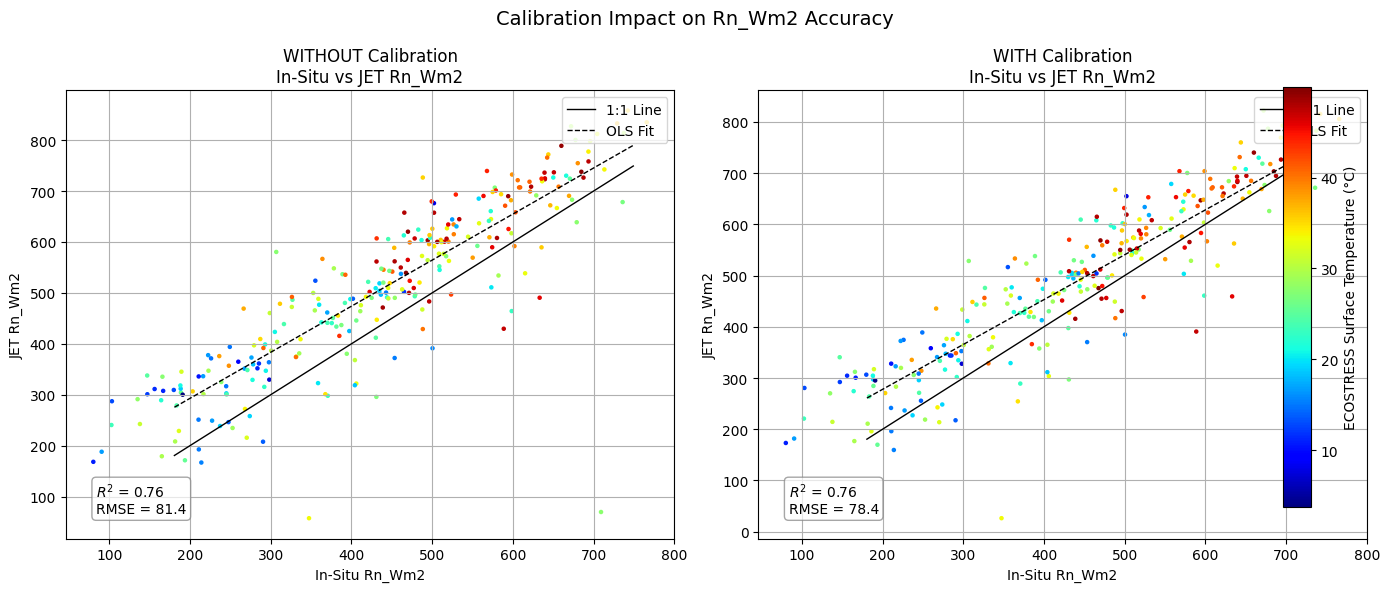

analyzing JET accuracy for Rn_daylight_Wm2 compared to insitu_Rn_daylight_Wm2
Error processing Rn_daylight_Wm2: "['Rn_daylight_Wm2'] not in index"
analyzing JET accuracy for SWin_Wm2 compared to insitu_SWin_Wm2


Traceback (most recent call last):
  File "/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_76501/1028714077.py", line 17, in <module>
    valid_data_uncal = processed_uncalibrated[[x_variable, y_variable, 'ST_C']].dropna()
                       ~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniforge/base/envs/JET3/lib/python3.12/site-packages/pandas/core/frame.py", line 4384, in __getitem__
    indexer = self.columns._get_indexer_strict(key, "columns")[1]
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniforge/base/envs/JET3/lib/python3.12/site-packages/pandas/core/indexes/base.py", line 6302, in _get_indexer_strict
    self._raise_if_missing(keyarr, indexer, axis_name)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/JET3/lib/python3.12/site-packages/pandas/core/indexes/base.py", line 6355, in _raise_if_missing
    raise KeyError(f"{not_found} not in index")
KeyError: "['Rn_daylight

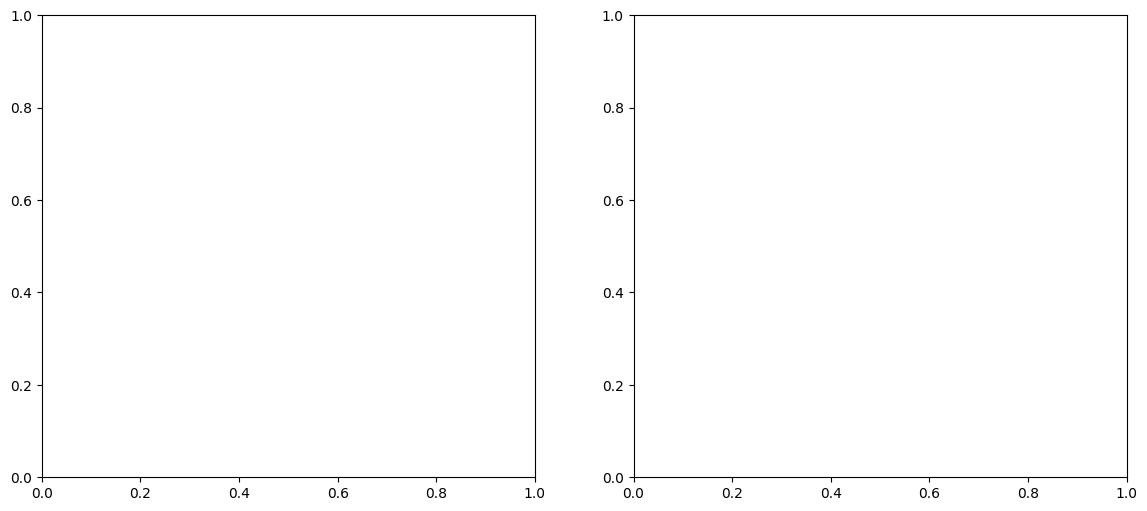

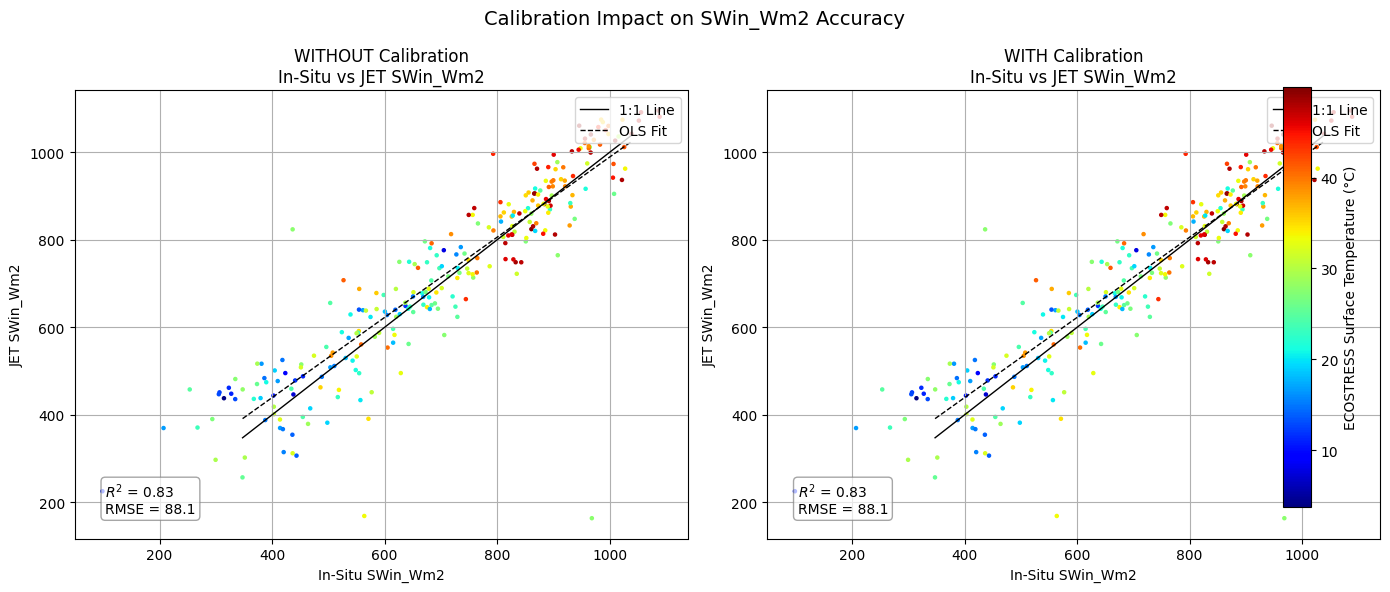

analyzing JET accuracy for Ta_C compared to insitu_Ta_C


/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_76501/1028714077.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


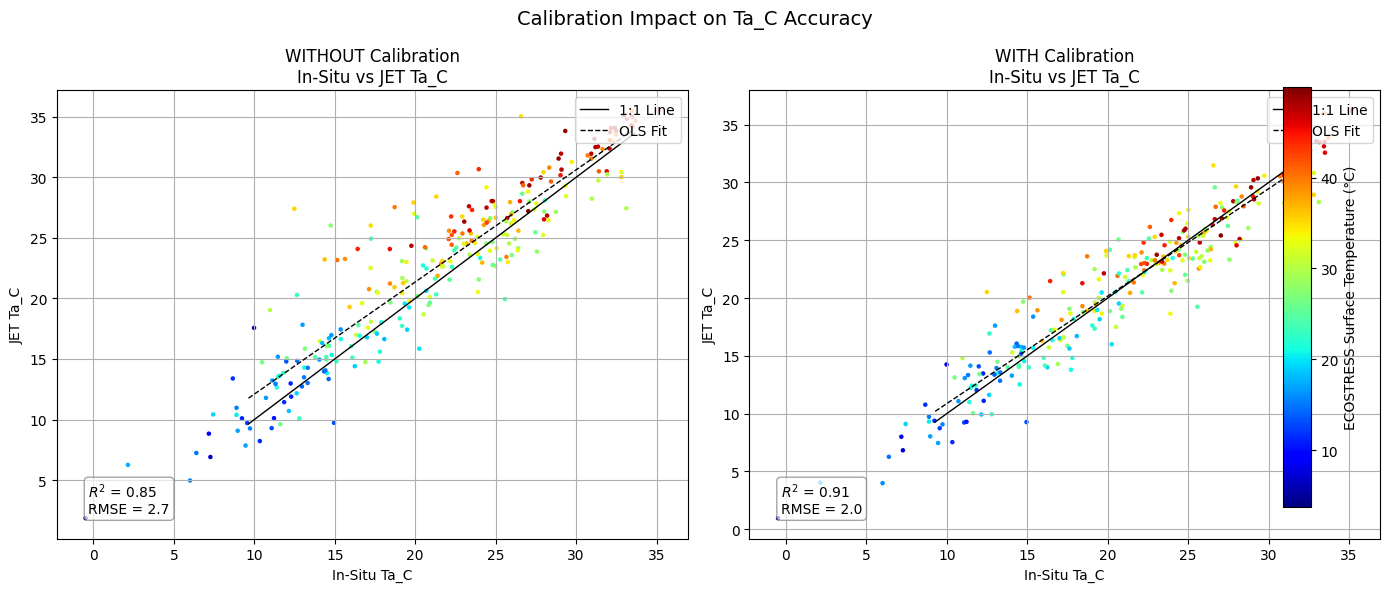

In [9]:
from sklearn.metrics import r2_score, mean_squared_error

insitu_columns = sorted([column for column in processed_calibrated.columns if "insitu" in column])

for insitu_variable in insitu_columns:
    try:
        output_variable = insitu_variable.replace("insitu_", "")
        print(f"analyzing {model_name} accuracy for {output_variable} compared to {insitu_variable}")
        
        x_variable = insitu_variable
        y_variable = output_variable

        # Create figure with 2 subplots (uncalibrated vs calibrated)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # ===== LEFT PLOT: UNCALIBRATED =====
        valid_data_uncal = processed_uncalibrated[[x_variable, y_variable, 'ST_C']].dropna()
        
        if len(valid_data_uncal) > 0:
            sc1 = ax1.scatter(
                x=valid_data_uncal[x_variable],
                y=valid_data_uncal[y_variable],
                c=valid_data_uncal.ST_C,
                cmap="jet",
                s=5
            )
            
            # Calculate 5% and 95% tails
            x_5th, x_95th = np.percentile(valid_data_uncal[x_variable], [5, 95])
            y_5th, y_95th = np.percentile(valid_data_uncal[y_variable], [5, 95])
            min_val = min(x_5th, y_5th)
            max_val = max(x_95th, y_95th)
            
            # 1:1 line
            ax1.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='-', linewidth=1, label='1:1 Line')
            
            # OLS regression
            coefs = np.polyfit(valid_data_uncal[x_variable], valid_data_uncal[y_variable], 1)
            ols_x = np.array([min_val, max_val])
            ols_y = coefs[0] * ols_x + coefs[1]
            ax1.plot(ols_x, ols_y, color='black', linestyle='--', linewidth=1, label='OLS Fit')
            
            # Calculate R² and RMSE
            y_true = valid_data_uncal[y_variable]
            y_pred = coefs[0] * valid_data_uncal[x_variable] + coefs[1]
            r2 = r2_score(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            
            ax1.annotate(f"$R^2$ = {r2:.2f}\nRMSE = {rmse:.1f}",
                        xy=(0.05, 0.05), xycoords='axes fraction',
                        ha='left', va='bottom', fontsize=10,
                        bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.7))
            
            ax1.grid(True, zorder=0)
            ax1.set_xlabel(f"In-Situ {output_variable}")
            ax1.set_ylabel(f"{model_name} {output_variable}")
            ax1.set_title(f"WITHOUT Calibration\nIn-Situ vs {model_name} {output_variable}")
            ax1.legend(loc='upper right')
        
        # ===== RIGHT PLOT: CALIBRATED =====
        valid_data_cal = processed_calibrated[[x_variable, y_variable, 'ST_C']].dropna()
        
        if len(valid_data_cal) > 0:
            sc2 = ax2.scatter(
                x=valid_data_cal[x_variable],
                y=valid_data_cal[y_variable],
                c=valid_data_cal.ST_C,
                cmap="jet",
                s=5
            )
            
            # Calculate 5% and 95% tails
            x_5th, x_95th = np.percentile(valid_data_cal[x_variable], [5, 95])
            y_5th, y_95th = np.percentile(valid_data_cal[y_variable], [5, 95])
            min_val = min(x_5th, y_5th)
            max_val = max(x_95th, y_95th)
            
            # 1:1 line
            ax2.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='-', linewidth=1, label='1:1 Line')
            
            # OLS regression
            coefs = np.polyfit(valid_data_cal[x_variable], valid_data_cal[y_variable], 1)
            ols_x = np.array([min_val, max_val])
            ols_y = coefs[0] * ols_x + coefs[1]
            ax2.plot(ols_x, ols_y, color='black', linestyle='--', linewidth=1, label='OLS Fit')
            
            # Calculate R² and RMSE
            y_true = valid_data_cal[y_variable]
            y_pred = coefs[0] * valid_data_cal[x_variable] + coefs[1]
            r2 = r2_score(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            
            ax2.annotate(f"$R^2$ = {r2:.2f}\nRMSE = {rmse:.1f}",
                        xy=(0.05, 0.05), xycoords='axes fraction',
                        ha='left', va='bottom', fontsize=10,
                        bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.7))
            
            ax2.grid(True, zorder=0)
            ax2.set_xlabel(f"In-Situ {output_variable}")
            ax2.set_ylabel(f"{model_name} {output_variable}")
            ax2.set_title(f"WITH Calibration\nIn-Situ vs {model_name} {output_variable}")
            ax2.legend(loc='upper right')
        
        # Add shared colorbar
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        fig.colorbar(sc2, cax=cbar_ax, label="ECOSTRESS Surface Temperature (°C)")
        
        plt.suptitle(f"Calibration Impact on {output_variable} Accuracy", fontsize=14, y=0.98)
        
        if SAVE_PLOTS:
            plt.savefig(f"Calibration Comparison of {output_variable}.jpeg", format='jpeg', bbox_inches='tight', dpi=150)
            plt.savefig(f"Calibration Comparison of {output_variable}.svg", format='svg', bbox_inches='tight')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error processing {output_variable}: {e}")
        import traceback
        traceback.print_exc()
        continue

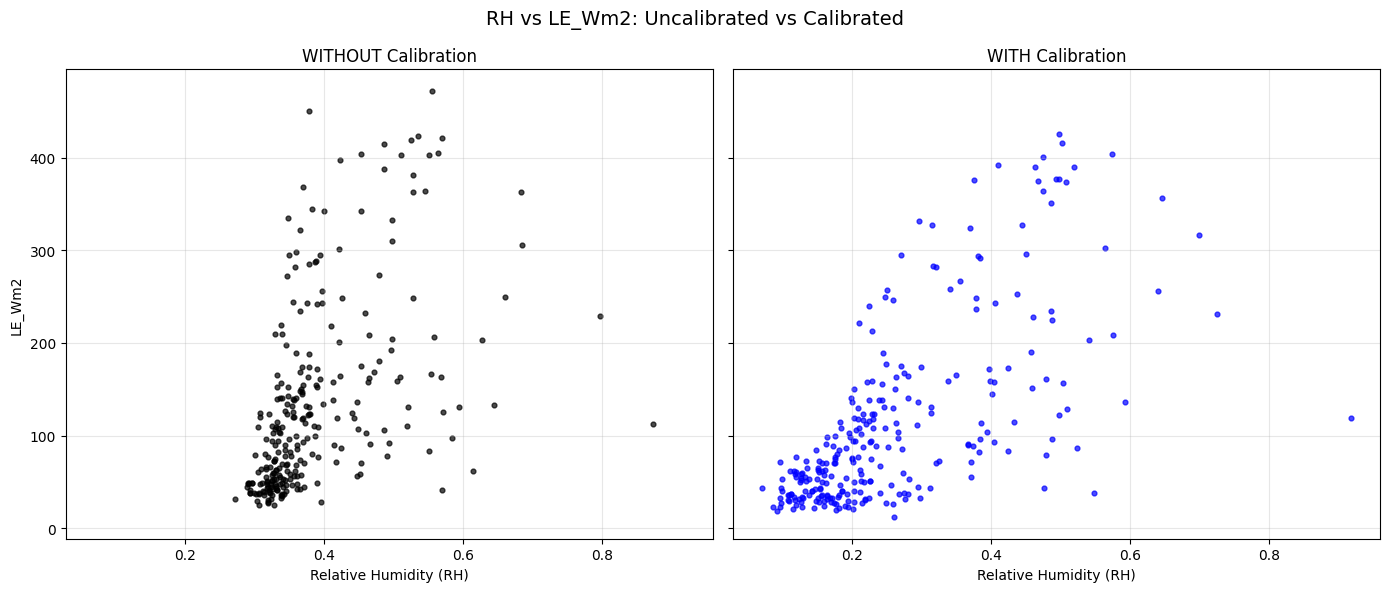

In [10]:
# RH vs LE_Wm2 scatter plots: uncalibrated vs calibrated
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Uncalibrated
df_uncal = processed_uncalibrated[["RH", "LE_Wm2"]].dropna()
ax1.scatter(df_uncal["RH"], df_uncal["LE_Wm2"], s=12, alpha=0.7, color="black")
ax1.set_title("WITHOUT Calibration")
ax1.set_xlabel("Relative Humidity (RH)")
ax1.set_ylabel("LE_Wm2")
ax1.grid(True, alpha=0.3)

# Calibrated
df_cal = processed_calibrated[["RH", "LE_Wm2"]].dropna()
ax2.scatter(df_cal["RH"], df_cal["LE_Wm2"], s=12, alpha=0.7, color="blue")
ax2.set_title("WITH Calibration")
ax2.set_xlabel("Relative Humidity (RH)")
ax2.grid(True, alpha=0.3)

plt.suptitle("RH vs LE_Wm2: Uncalibrated vs Calibrated", fontsize=14, y=0.98)
plt.tight_layout()

if SAVE_PLOTS:
    plt.savefig("RH_vs_LE_Wm2_Calibration_Comparison.jpeg", format="jpeg", bbox_inches="tight", dpi=150)
    plt.savefig("RH_vs_LE_Wm2_Calibration_Comparison.svg", format="svg", bbox_inches="tight")

plt.show()

# Net Radiation Accuracy Comparison: BESS vs Verma (With/Without Calibration)

analyzing JET accuracy for Rn_BESS_Wm2 compared to insitu_Rn_Wm2


/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_76501/2034817545.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


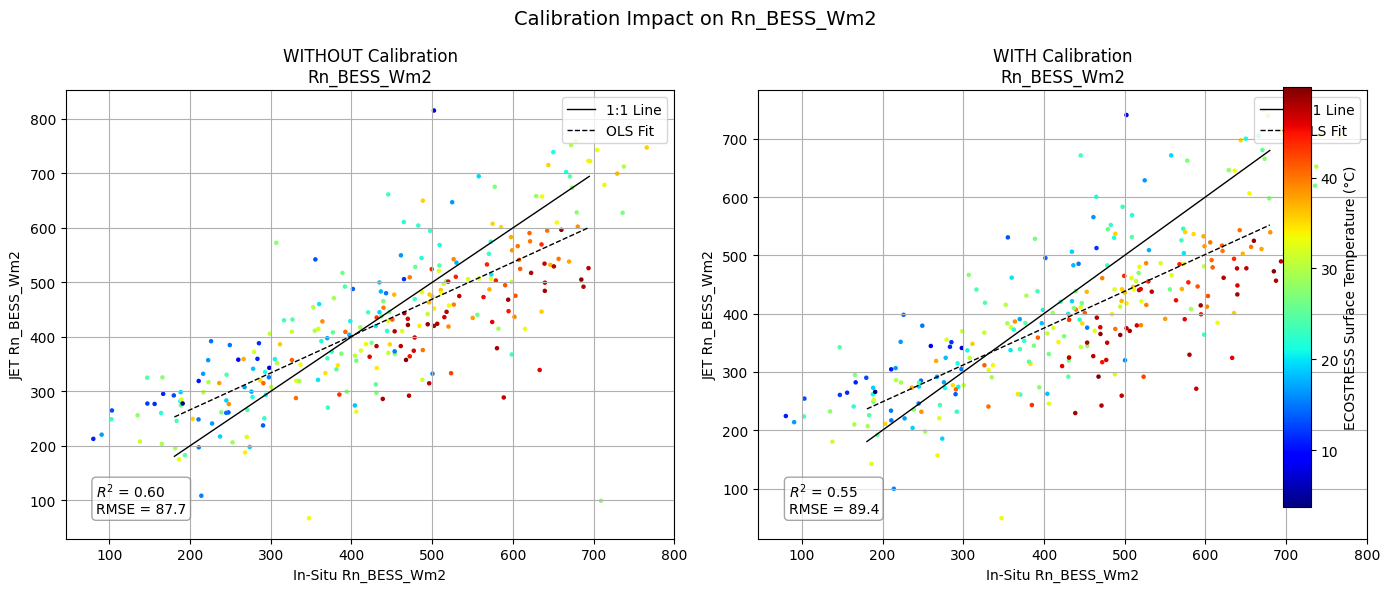

analyzing JET accuracy for Rn_verma_Wm2 compared to insitu_Rn_Wm2


/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_76501/2034817545.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


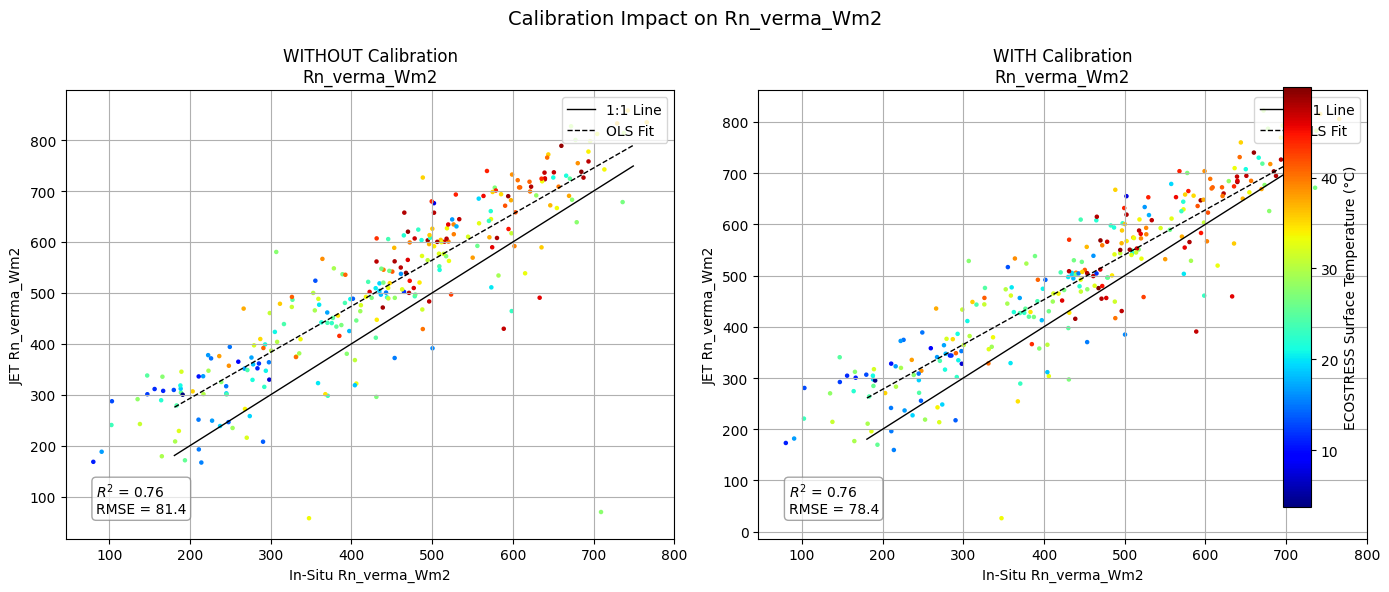

In [11]:
insitu_variable = "insitu_Rn_Wm2"

for output_variable in ["Rn_BESS_Wm2", "Rn_verma_Wm2"]:
    try:
        print(f"analyzing {model_name} accuracy for {output_variable} compared to {insitu_variable}")
        
        x_variable = insitu_variable
        y_variable = output_variable

        # Create figure with 2 subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # ===== LEFT: UNCALIBRATED =====
        valid_data_uncal = processed_uncalibrated[[x_variable, y_variable, 'ST_C']].dropna()
        
        if len(valid_data_uncal) > 0:
            sc1 = ax1.scatter(
                x=valid_data_uncal[x_variable],
                y=valid_data_uncal[y_variable],
                c=valid_data_uncal.ST_C,
                cmap="jet",
                s=5
            )
            
            x_5th, x_95th = np.percentile(valid_data_uncal[x_variable], [5, 95])
            y_5th, y_95th = np.percentile(valid_data_uncal[y_variable], [5, 95])
            min_val = min(x_5th, y_5th)
            max_val = max(x_95th, y_95th)
            
            ax1.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='-', linewidth=1, label='1:1 Line')
            
            coefs = np.polyfit(valid_data_uncal[x_variable], valid_data_uncal[y_variable], 1)
            ols_x = np.array([min_val, max_val])
            ols_y = coefs[0] * ols_x + coefs[1]
            ax1.plot(ols_x, ols_y, color='black', linestyle='--', linewidth=1, label='OLS Fit')
            
            y_true = valid_data_uncal[y_variable]
            y_pred = coefs[0] * valid_data_uncal[x_variable] + coefs[1]
            r2 = r2_score(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            
            ax1.annotate(f"$R^2$ = {r2:.2f}\nRMSE = {rmse:.1f}",
                        xy=(0.05, 0.05), xycoords='axes fraction',
                        ha='left', va='bottom', fontsize=10,
                        bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.7))
            
            ax1.grid(True, zorder=0)
            ax1.set_xlabel(f"In-Situ {output_variable}")
            ax1.set_ylabel(f"{model_name} {output_variable}")
            ax1.set_title(f"WITHOUT Calibration\n{output_variable}")
            ax1.legend(loc='upper right')
        
        # ===== RIGHT: CALIBRATED =====
        valid_data_cal = processed_calibrated[[x_variable, y_variable, 'ST_C']].dropna()
        
        if len(valid_data_cal) > 0:
            sc2 = ax2.scatter(
                x=valid_data_cal[x_variable],
                y=valid_data_cal[y_variable],
                c=valid_data_cal.ST_C,
                cmap="jet",
                s=5
            )
            
            x_5th, x_95th = np.percentile(valid_data_cal[x_variable], [5, 95])
            y_5th, y_95th = np.percentile(valid_data_cal[y_variable], [5, 95])
            min_val = min(x_5th, y_5th)
            max_val = max(x_95th, y_95th)
            
            ax2.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='-', linewidth=1, label='1:1 Line')
            
            coefs = np.polyfit(valid_data_cal[x_variable], valid_data_cal[y_variable], 1)
            ols_x = np.array([min_val, max_val])
            ols_y = coefs[0] * ols_x + coefs[1]
            ax2.plot(ols_x, ols_y, color='black', linestyle='--', linewidth=1, label='OLS Fit')
            
            y_true = valid_data_cal[y_variable]
            y_pred = coefs[0] * valid_data_cal[x_variable] + coefs[1]
            r2 = r2_score(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            
            ax2.annotate(f"$R^2$ = {r2:.2f}\nRMSE = {rmse:.1f}",
                        xy=(0.05, 0.05), xycoords='axes fraction',
                        ha='left', va='bottom', fontsize=10,
                        bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.7))
            
            ax2.grid(True, zorder=0)
            ax2.set_xlabel(f"In-Situ {output_variable}")
            ax2.set_ylabel(f"{model_name} {output_variable}")
            ax2.set_title(f"WITH Calibration\n{output_variable}")
            ax2.legend(loc='upper right')
        
        # Colorbar
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        fig.colorbar(sc2, cax=cbar_ax, label="ECOSTRESS Surface Temperature (°C)")
        
        plt.suptitle(f"Calibration Impact on {output_variable}", fontsize=14, y=0.98)
        
        if SAVE_PLOTS:
            plt.savefig(f"Calibration Comparison of {output_variable}.jpeg", format='jpeg', bbox_inches='tight', dpi=150)
            plt.savefig(f"Calibration Comparison of {output_variable}.svg", format='svg', bbox_inches='tight')
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error processing {output_variable}: {e}")
        import traceback
        traceback.print_exc()
        continue

analyzing JET accuracy for LE_BESS_Wm2 compared to insitu_LE_Wm2


/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_76501/175198646.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


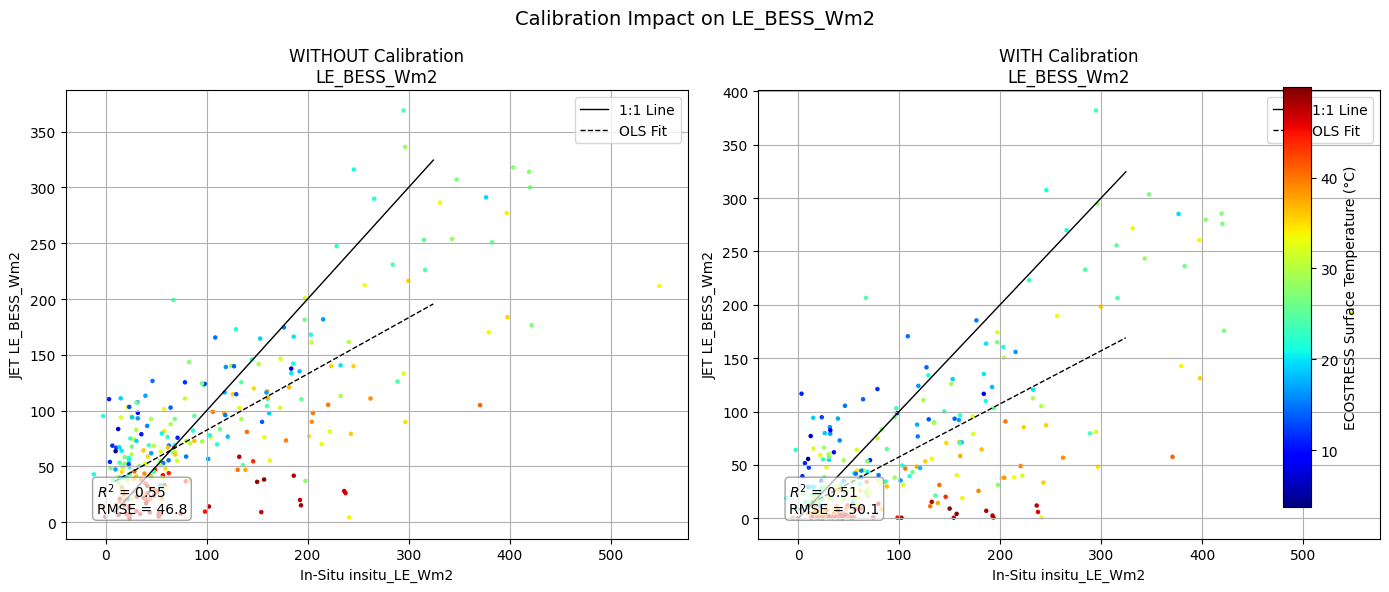

analyzing JET accuracy for LE_STIC_Wm2 compared to insitu_LE_Wm2


/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_76501/175198646.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


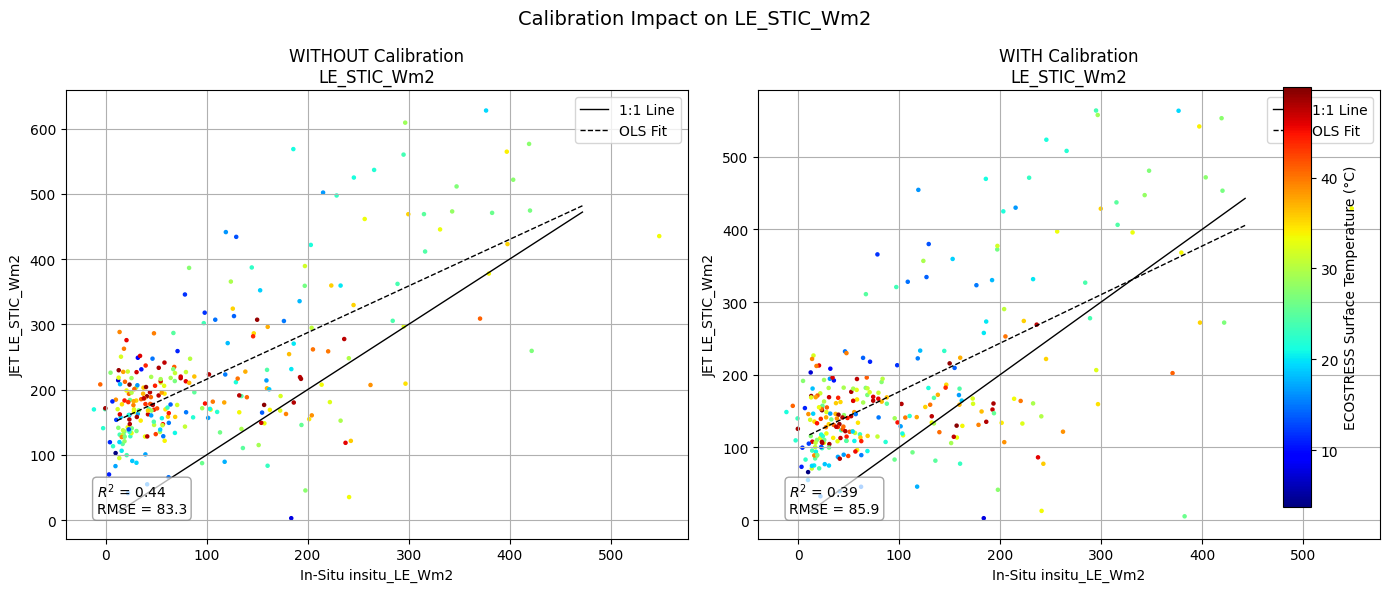

analyzing JET accuracy for LE_PTJPLSM_Wm2 compared to insitu_LE_Wm2


/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_76501/175198646.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


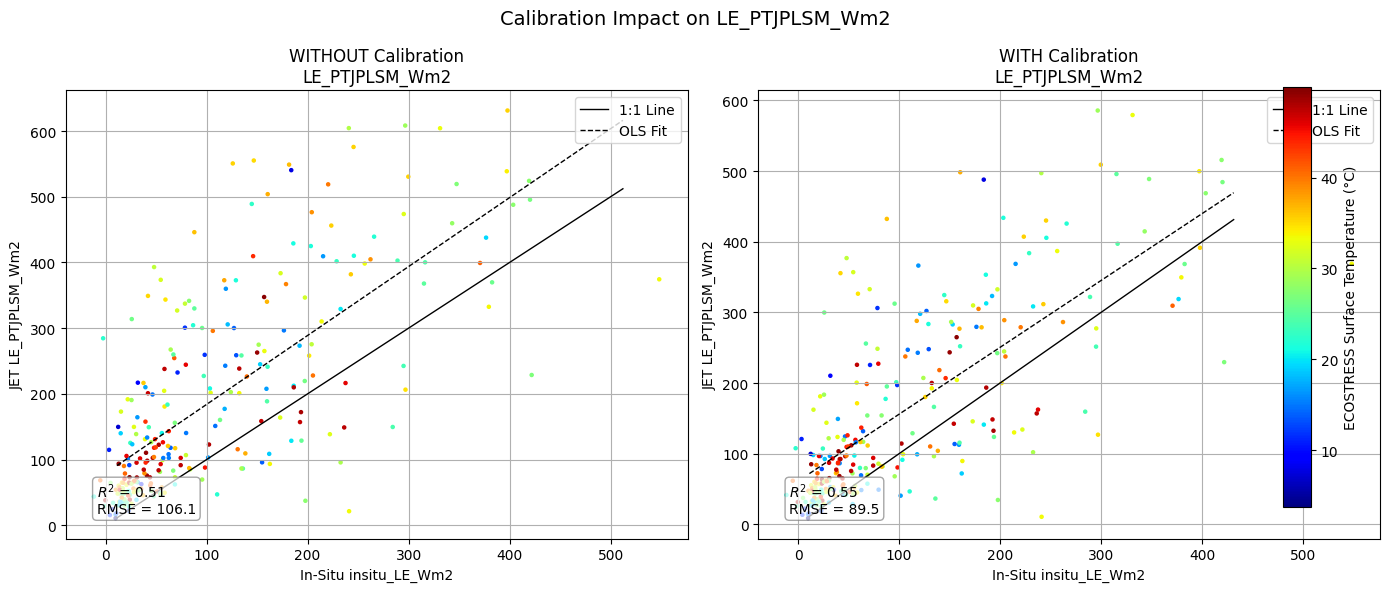

analyzing JET accuracy for LE_PMJPL_Wm2 compared to insitu_LE_Wm2


/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_76501/175198646.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


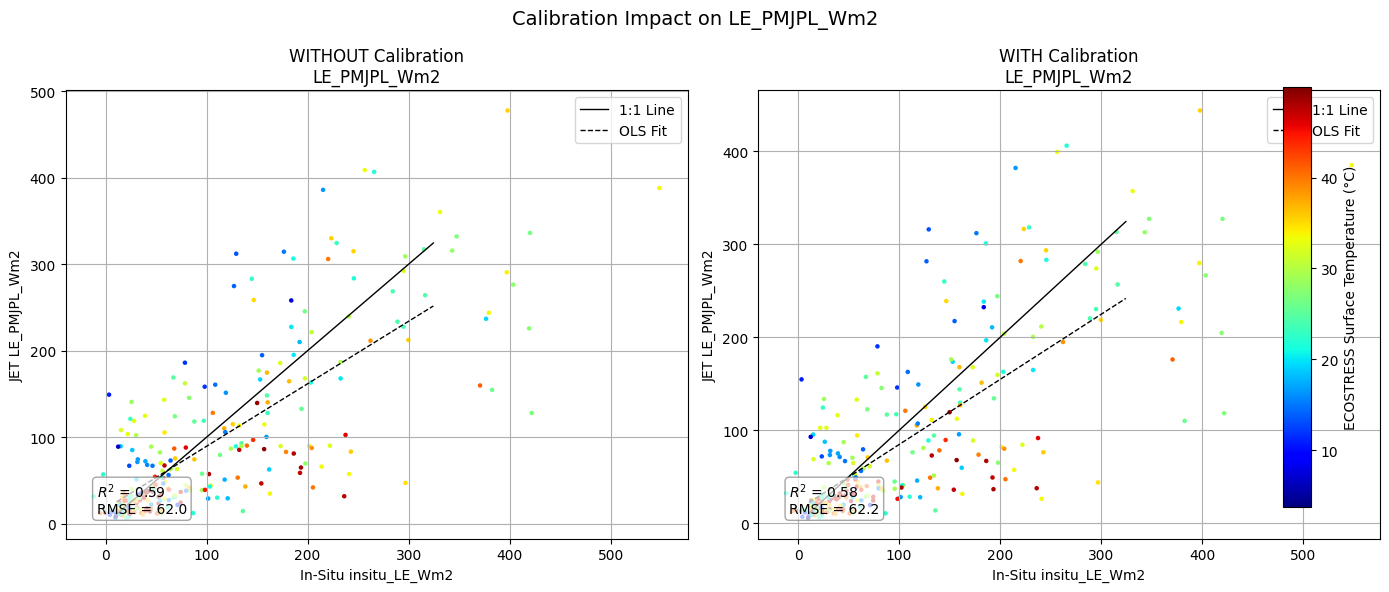

analyzing JET accuracy for LE_Wm2 compared to insitu_LE_Wm2


/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_76501/175198646.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


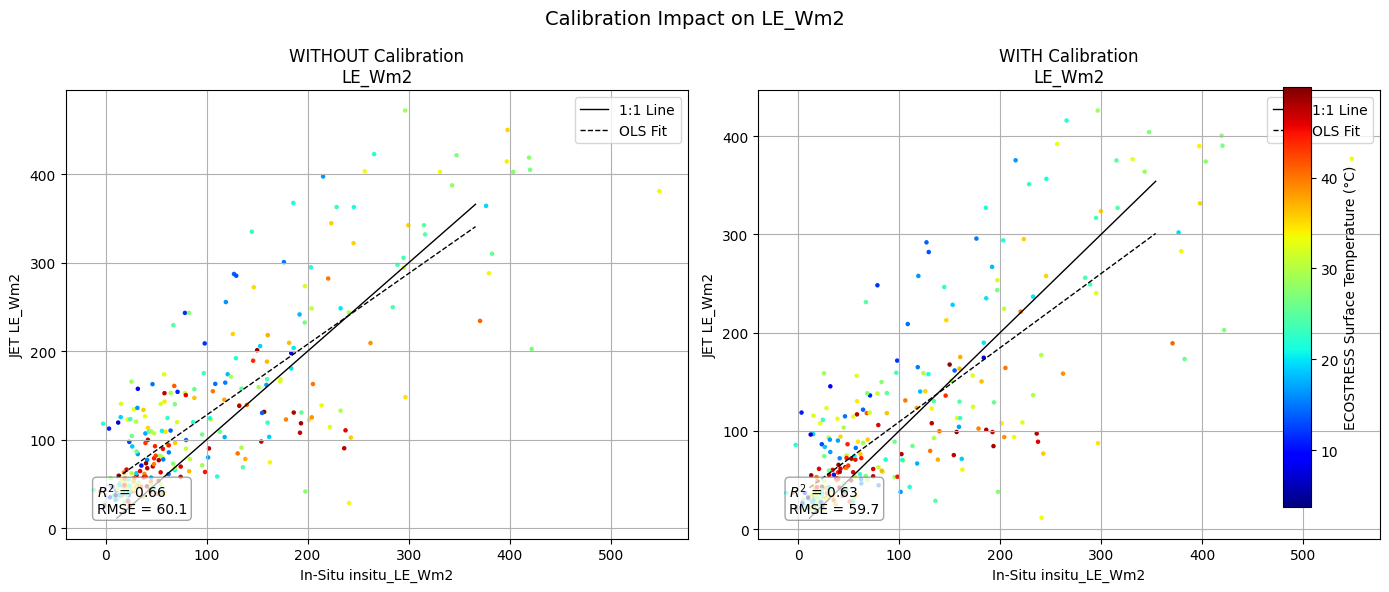

In [12]:
insitu_variable = "insitu_LE_Wm2"

output_variables = [
    "LE_BESS_Wm2",
    "LE_STIC_Wm2",
    "LE_PTJPLSM_Wm2",
    "LE_PMJPL_Wm2",
    "LE_Wm2"
]

for output_variable in output_variables:
    try:
        print(f"analyzing {model_name} accuracy for {output_variable} compared to {insitu_variable}")
        
        x_variable = insitu_variable
        y_variable = output_variable

        # Create figure with 2 subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # ===== LEFT: UNCALIBRATED =====
        valid_data_uncal = processed_uncalibrated[[x_variable, y_variable, 'ST_C']].dropna()
        
        if len(valid_data_uncal) > 0:
            sc1 = ax1.scatter(
                x=valid_data_uncal[x_variable],
                y=valid_data_uncal[y_variable],
                c=valid_data_uncal.ST_C,
                cmap="jet",
                s=5
            )
            
            x_5th, x_95th = np.percentile(valid_data_uncal[x_variable], [5, 95])
            y_5th, y_95th = np.percentile(valid_data_uncal[y_variable], [5, 95])
            min_val = min(x_5th, y_5th)
            max_val = max(x_95th, y_95th)
            
            ax1.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='-', linewidth=1, label='1:1 Line')
            
            coefs = np.polyfit(valid_data_uncal[x_variable], valid_data_uncal[y_variable], 1)
            ols_x = np.array([min_val, max_val])
            ols_y = coefs[0] * ols_x + coefs[1]
            ax1.plot(ols_x, ols_y, color='black', linestyle='--', linewidth=1, label='OLS Fit')
            
            y_true = valid_data_uncal[y_variable]
            y_pred = coefs[0] * valid_data_uncal[x_variable] + coefs[1]
            r2 = r2_score(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            
            ax1.annotate(f"$R^2$ = {r2:.2f}\nRMSE = {rmse:.1f}",
                        xy=(0.05, 0.05), xycoords='axes fraction',
                        ha='left', va='bottom', fontsize=10,
                        bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.7))
            
            ax1.grid(True, zorder=0)
            ax1.set_xlabel(f"In-Situ {insitu_variable}")
            ax1.set_ylabel(f"{model_name} {output_variable}")
            ax1.set_title(f"WITHOUT Calibration\n{output_variable}")
            ax1.legend(loc='upper right')
        
        # ===== RIGHT: CALIBRATED =====
        valid_data_cal = processed_calibrated[[x_variable, y_variable, 'ST_C']].dropna()
        
        if len(valid_data_cal) > 0:
            sc2 = ax2.scatter(
                x=valid_data_cal[x_variable],
                y=valid_data_cal[y_variable],
                c=valid_data_cal.ST_C,
                cmap="jet",
                s=5
            )
            
            x_5th, x_95th = np.percentile(valid_data_cal[x_variable], [5, 95])
            y_5th, y_95th = np.percentile(valid_data_cal[y_variable], [5, 95])
            min_val = min(x_5th, y_5th)
            max_val = max(x_95th, y_95th)
            
            ax2.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='-', linewidth=1, label='1:1 Line')
            
            coefs = np.polyfit(valid_data_cal[x_variable], valid_data_cal[y_variable], 1)
            ols_x = np.array([min_val, max_val])
            ols_y = coefs[0] * ols_x + coefs[1]
            ax2.plot(ols_x, ols_y, color='black', linestyle='--', linewidth=1, label='OLS Fit')
            
            y_true = valid_data_cal[y_variable]
            y_pred = coefs[0] * valid_data_cal[x_variable] + coefs[1]
            r2 = r2_score(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            
            ax2.annotate(f"$R^2$ = {r2:.2f}\nRMSE = {rmse:.1f}",
                        xy=(0.05, 0.05), xycoords='axes fraction',
                        ha='left', va='bottom', fontsize=10,
                        bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.7))
            
            ax2.grid(True, zorder=0)
            ax2.set_xlabel(f"In-Situ {insitu_variable}")
            ax2.set_ylabel(f"{model_name} {output_variable}")
            ax2.set_title(f"WITH Calibration\n{output_variable}")
            ax2.legend(loc='upper right')
        
        # Colorbar
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        fig.colorbar(sc2, cax=cbar_ax, label="ECOSTRESS Surface Temperature (°C)")
        
        plt.suptitle(f"Calibration Impact on {output_variable}", fontsize=14, y=0.98)
        
        if SAVE_PLOTS:
            plt.savefig(f"Calibration Comparison of {output_variable}.jpeg", format='jpeg', bbox_inches='tight', dpi=150)
            plt.savefig(f"Calibration Comparison of {output_variable}.svg", format='svg', bbox_inches='tight')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error processing {output_variable}: {e}")
        import traceback
        traceback.print_exc()
        continue

## Surface Temperature vs Net Radiation Comparison (With/Without Calibration)

Side-by-side comparison showing how calibration affects the relationship between surface temperature and net radiation.

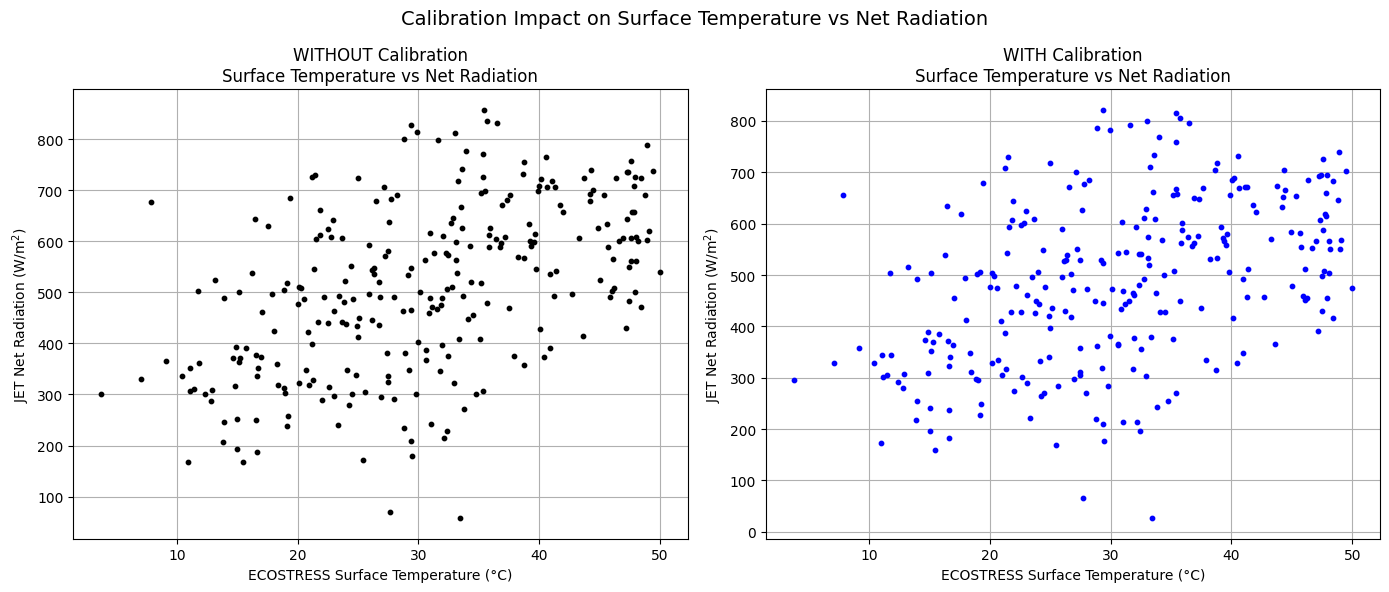

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# LEFT: Uncalibrated
ax1.scatter(x=processed_uncalibrated.ST_C, y=processed_uncalibrated.Rn_Wm2, color='black', s=10, zorder=5)
ax1.grid(True, zorder=0)
ax1.set_xlabel("ECOSTRESS Surface Temperature (°C)")
ax1.set_ylabel(f"{model_name} Net Radiation (W/m$^2$)")
ax1.set_title(f"WITHOUT Calibration\nSurface Temperature vs Net Radiation")

# RIGHT: Calibrated
ax2.scatter(x=processed_calibrated.ST_C, y=processed_calibrated.Rn_Wm2, color='blue', s=10, zorder=5)
ax2.grid(True, zorder=0)
ax2.set_xlabel("ECOSTRESS Surface Temperature (°C)")
ax2.set_ylabel(f"{model_name} Net Radiation (W/m$^2$)")
ax2.set_title(f"WITH Calibration\nSurface Temperature vs Net Radiation")

plt.suptitle(f"Calibration Impact on Surface Temperature vs Net Radiation", fontsize=14, y=0.98)

if SAVE_PLOTS:
    plt.savefig(f"Calibration Comparison Surface Temperature to Net Radiation.jpeg", format='jpeg', bbox_inches='tight', dpi=150)
    plt.savefig(f"Calibration Comparison Surface Temperature to Net Radiation.svg", format='svg', bbox_inches='tight')

plt.tight_layout()
plt.show()

## Surface Temperature vs Evapotranspiration Comparison (With/Without Calibration)

Side-by-side comparison showing how calibration affects the relationship between surface temperature and evapotranspiration.

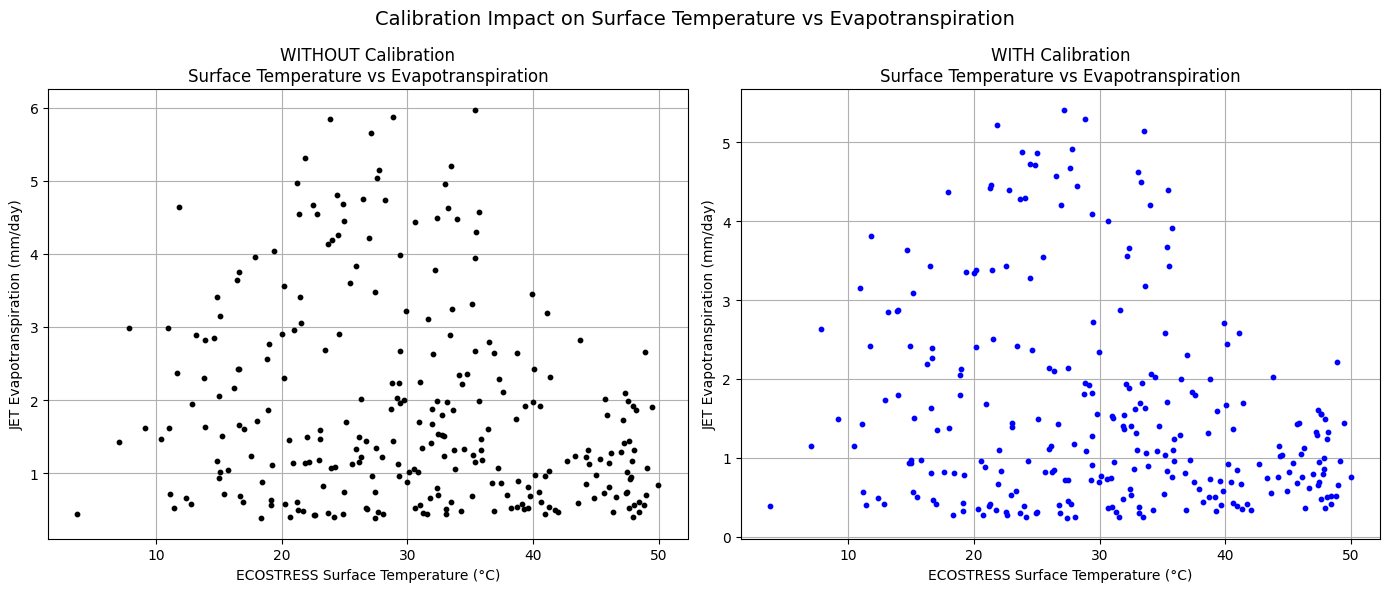

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# LEFT: Uncalibrated
ax1.scatter(x=processed_uncalibrated.ST_C, y=processed_uncalibrated.ET_daylight_kg, color='black', s=10, zorder=5)
ax1.grid(True, zorder=0)
ax1.set_xlabel("ECOSTRESS Surface Temperature (°C)")
ax1.set_ylabel(f"{model_name} Evapotranspiration (mm/day)")
ax1.set_title(f"WITHOUT Calibration\nSurface Temperature vs Evapotranspiration")

# RIGHT: Calibrated  
ax2.scatter(x=processed_calibrated.ST_C, y=processed_calibrated.ET_daylight_kg, color='blue', s=10, zorder=5)
ax2.grid(True, zorder=0)
ax2.set_xlabel("ECOSTRESS Surface Temperature (°C)")
ax2.set_ylabel(f"{model_name} Evapotranspiration (mm/day)")
ax2.set_title(f"WITH Calibration\nSurface Temperature vs Evapotranspiration")

plt.suptitle(f"Calibration Impact on Surface Temperature vs Evapotranspiration", fontsize=14, y=0.98)

if SAVE_PLOTS:
    plt.savefig(f"Calibration Comparison Surface Temperature to Evapotranspiration.jpeg", format='jpeg', bbox_inches='tight', dpi=150)
    plt.savefig(f"Calibration Comparison Surface Temperature to Evapotranspiration.svg", format='svg', bbox_inches='tight')

plt.tight_layout()
plt.show()

## Summary Statistics: Calibration Impact

Calculate and display summary statistics comparing uncalibrated vs calibrated model performance.

In [15]:
# Calculate summary statistics for key variables
summary_data = []

insitu_columns = sorted([column for column in processed_calibrated.columns if "insitu" in column])

for insitu_variable in insitu_columns:
    output_variable = insitu_variable.replace("insitu_", "")
    
    if output_variable not in processed_uncalibrated.columns or output_variable not in processed_calibrated.columns:
        continue
    
    # Uncalibrated metrics
    valid_uncal = processed_uncalibrated[[insitu_variable, output_variable]].dropna()
    if len(valid_uncal) > 0:
        r2_uncal = r2_score(valid_uncal[insitu_variable], valid_uncal[output_variable])
        rmse_uncal = np.sqrt(mean_squared_error(valid_uncal[insitu_variable], valid_uncal[output_variable]))
    else:
        r2_uncal = np.nan
        rmse_uncal = np.nan
    
    # Calibrated metrics
    valid_cal = processed_calibrated[[insitu_variable, output_variable]].dropna()
    if len(valid_cal) > 0:
        r2_cal = r2_score(valid_cal[insitu_variable], valid_cal[output_variable])
        rmse_cal = np.sqrt(mean_squared_error(valid_cal[insitu_variable], valid_cal[output_variable]))
    else:
        r2_cal = np.nan
        rmse_cal = np.nan
    
    # Calculate improvements
    r2_improvement = r2_cal - r2_uncal
    rmse_improvement = rmse_uncal - rmse_cal  # Positive means improvement (lower RMSE)
    rmse_percent_improvement = (rmse_improvement / rmse_uncal) * 100 if rmse_uncal > 0 else np.nan
    
    summary_data.append({
        'Variable': output_variable,
        'R² (Uncalibrated)': f"{r2_uncal:.3f}",
        'R² (Calibrated)': f"{r2_cal:.3f}",
        'ΔR²': f"{r2_improvement:+.3f}",
        'RMSE (Uncalibrated)': f"{rmse_uncal:.2f}",
        'RMSE (Calibrated)': f"{rmse_cal:.2f}",
        'ΔRMSE': f"{rmse_improvement:+.2f}",
        'RMSE % Improvement': f"{rmse_percent_improvement:.1f}%"
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*100)
print("CALIBRATION IMPACT SUMMARY")
print("="*100)
print(summary_df.to_string(index=False))
print("="*100)
print("\nNote: Positive ΔR² indicates improvement (higher R²)")
print("      Positive ΔRMSE indicates improvement (lower RMSE)")
print("      Positive % Improvement indicates calibration improved accuracy")
print("="*100)


CALIBRATION IMPACT SUMMARY
      Variable R² (Uncalibrated) R² (Calibrated)    ΔR² RMSE (Uncalibrated) RMSE (Calibrated)  ΔRMSE RMSE % Improvement
ET_daylight_kg             0.537           0.562 +0.024                1.02              1.00  +0.03               2.6%
         G_Wm2             0.435           0.451 +0.016               46.43             45.76  +0.67               1.4%
         H_Wm2             0.323           0.294 -0.029              102.90            105.11  -2.21              -2.1%
        LE_Wm2             0.558           0.602 +0.044               68.86             65.33  +3.53               5.1%
            RH             0.033           0.701 +0.668                0.17              0.09  +0.07              44.4%
        Rn_Wm2             0.527           0.644 +0.117              108.59             94.18 +14.41              13.3%
      SWin_Wm2             0.812           0.812 +0.000               90.92             90.92  +0.00               0.0%
          Ta

## Visual Comparison of Calibration Impact

Bar charts showing R² and RMSE improvements from calibration.

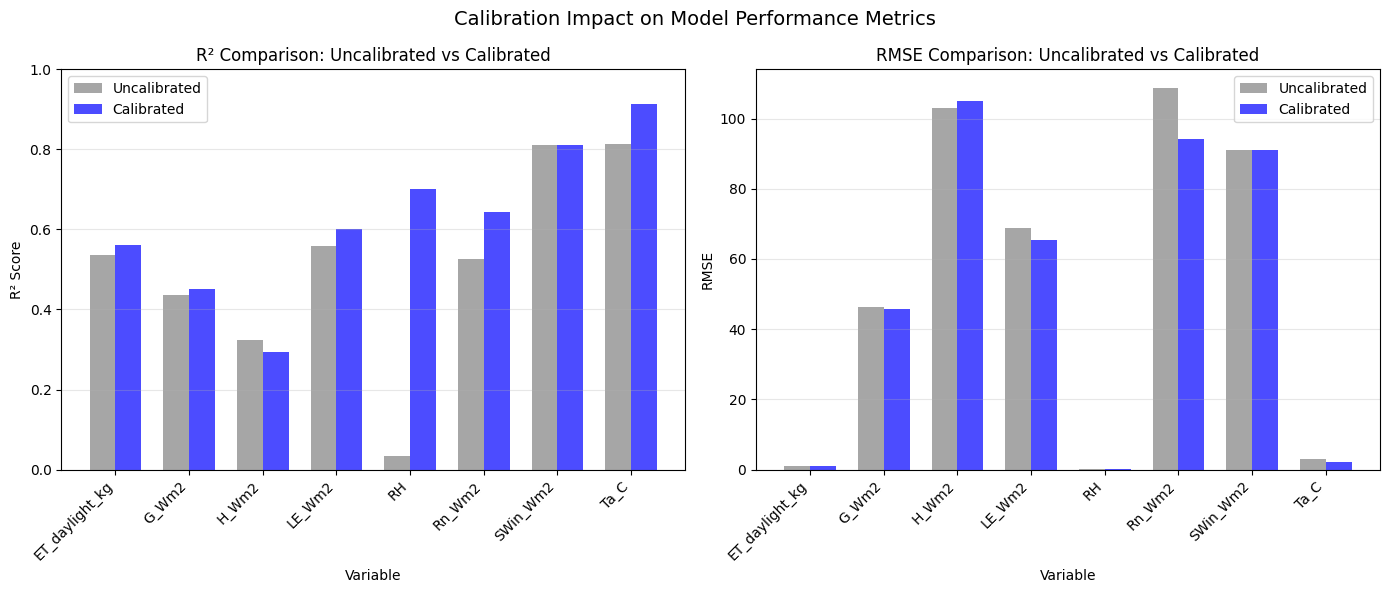


Interpretation:
- LEFT: Higher R² bars indicate better model fit (calibrated should be higher)
- RIGHT: Lower RMSE bars indicate better accuracy (calibrated should be lower)


In [16]:
# Create visual comparison of calibration impact
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Extract numeric values for plotting
variables = []
r2_uncal_values = []
r2_cal_values = []
rmse_uncal_values = []
rmse_cal_values = []

for item in summary_data:
    variables.append(item['Variable'])
    r2_uncal_values.append(float(item['R² (Uncalibrated)']))
    r2_cal_values.append(float(item['R² (Calibrated)']))
    rmse_uncal_values.append(float(item['RMSE (Uncalibrated)']))
    rmse_cal_values.append(float(item['RMSE (Calibrated)']))

x = np.arange(len(variables))
width = 0.35

# R² comparison
bars1 = ax1.bar(x - width/2, r2_uncal_values, width, label='Uncalibrated', color='gray', alpha=0.7)
bars2 = ax1.bar(x + width/2, r2_cal_values, width, label='Calibrated', color='blue', alpha=0.7)
ax1.set_xlabel('Variable')
ax1.set_ylabel('R² Score')
ax1.set_title('R² Comparison: Uncalibrated vs Calibrated')
ax1.set_xticks(x)
ax1.set_xticklabels(variables, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0, 1])

# RMSE comparison  
bars3 = ax2.bar(x - width/2, rmse_uncal_values, width, label='Uncalibrated', color='gray', alpha=0.7)
bars4 = ax2.bar(x + width/2, rmse_cal_values, width, label='Calibrated', color='blue', alpha=0.7)
ax2.set_xlabel('Variable')
ax2.set_ylabel('RMSE')
ax2.set_title('RMSE Comparison: Uncalibrated vs Calibrated')
ax2.set_xticks(x)
ax2.set_xticklabels(variables, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.suptitle('Calibration Impact on Model Performance Metrics', fontsize=14, y=0.98)
plt.tight_layout()

if SAVE_PLOTS:
    plt.savefig(f"Calibration Impact Metrics Comparison.jpeg", format='jpeg', bbox_inches='tight', dpi=150)
    plt.savefig(f"Calibration Impact Metrics Comparison.svg", format='svg', bbox_inches='tight')

plt.show()

print("\nInterpretation:")
print("- LEFT: Higher R² bars indicate better model fit (calibrated should be higher)")
print("- RIGHT: Lower RMSE bars indicate better accuracy (calibrated should be lower)")